### Imports

In [5]:
import numpy as _np
import matplotlib.pyplot as _plt
import pandas as _pd
import glob as _gl
import pymad8 as _m8
import pybdsim as _bd
import beamWire
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import integrate

### Date and prefix

In [6]:
date = "2023_07_13"
save_name_prefix = "plots/BeamWire/" + date + "_T20_plot"

# Analytical and Numerical convolutions

In [7]:
#beamWire.analyticConvolution()

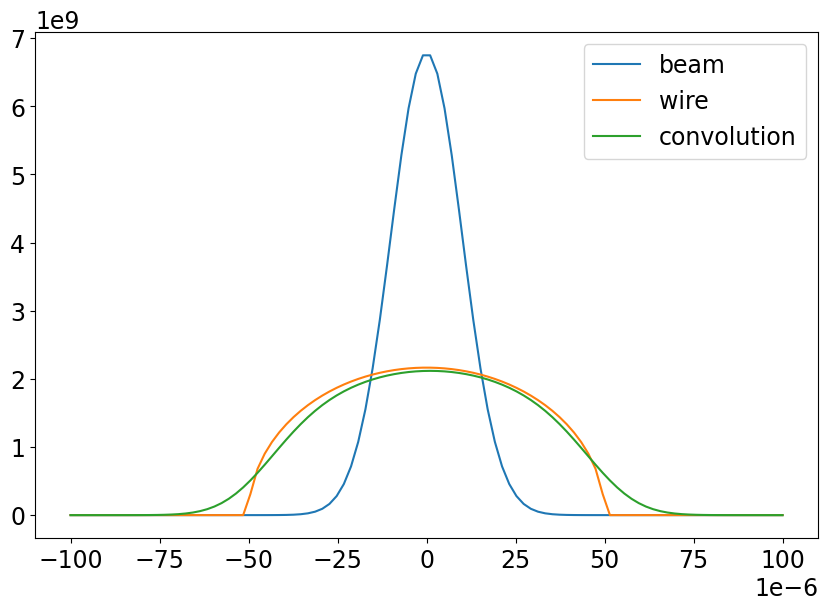

In [8]:
beamWire.PlotConvolutionExampleWire(a=1.7e5, b=1.7e5, A=1.7e5)
_plt.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
_plt.savefig("{}_convolution_example_wire".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

# Create gmad files sets

In [9]:
#beamWire.GenerateSetGmadFiles(tag="T20_wire_fullline", wireOffsetX='+1.00')

In [10]:
#beamWire.GenerateSetGmadFiles(tag="T20_wire", wireDiameter=0.1, wireLength=0.03, material='tungsten', wireOffsetX='+0.00',
#                              alfx=0.523492, alfy=-5.374594, betx=1.219804, bety=28.061506, 
#                              dispx=0.144685, dispxp=-0.039822, dispy=-0.004589, dispyp=-0.002385,
#                              sigmaE=1.377e-5, line='l7')

In [11]:
#beamWire.GenerateAllGmadFilesAndList(tag="T20_wire", valuetoscan='wireOffsetX', 
#                                     valuelist=beamWire.GenerateLinearListValuesStr(minValue=-1.5, maxValue=0, nbpts=31, nbDecimals=2, exponant=-3), 
#                                     xsecfact='1e0', wireDiameter=0.1, wireLength=0.03, material='tungsten',
#                                     alfx=0.523492, alfy=-5.374594, betx=1.219804, bety=28.061506, 
#                                     dispx=0.144685, dispxp=-0.039822, dispy=-0.004589, dispyp=-0.002385,
#                                     sigmaE=1.377e-5, line='l7')

# BDSIM run and Python analysis

In [25]:
#beamWire.runOneOffset("../03_bdsimModel/T20_needle_X_+0.00e-5_Y_+0.00e-3.gmad", npart=20000, seed=None, silent=False)
#beamWire.runOneOffset("../03_bdsimModel/TEST_T20_wire_offset_+0.00_bias_1e0.gmad", npart=10000, seed=0, silent=False)
beamWire.analysis("../04_dataLocal/20000_part_T20_needle_X_+0.00e-5_Y_+0.00e-3.root")

BDSIM output file - using DataLoader
File : ../04_dataLocal/20000_part_T20_needle_X_+0.00e-5_Y_+0.00e-3.root  / Nb of entries =  20000


In [23]:
beamWire.runScanOffset(tagfilelist="tagfilelistneedle", npart=20000, seed=None, silent=True)

Run BDSIM on file ../03_bdsimModel/T20_needle_X_+0.00e-5_Y_+0.00e-3.gmad with 20000 particles: |██████████████████████████████████████████████████| 100.0% Complete
Succesfull BDSIM run for 31 files with 20000 particles


In [24]:
#beamWire.analysis(_gl.glob('../04_dataLocal/10000_part_T20_wire_offset_[-+]0.[0-1][0-9][0-9]_bias_1e0.root'))
beamWire.analysis(_gl.glob('../04_dataLocal/20000_part_T20_needle_X_+0.00e-5*.root'))

Run REBDSIM analysis on file ../04_dataLocal/20000_part_T20_needle_X_+0.00e-5_Y_-0.85e-3.root: |██████████████████████████████████████████████████| 100.0% Complete
Succesfull REBDSIM analysis for 31 files


0

In [12]:
OFFSETS, NPHOTONS, ERRORS = beamWire.countPhotonsInHistAllFiles('../06_analysis/T20_wire_offset_[-+]0.[0-1][0-9][0-9]_bias_1e0_merged_hist.root', 'PHOTONS_R')
#OFFSETS, NPHOTONS, ERRORS = beamWire.countPhotonsInHistAllFiles('../06_analysis/10000_part_T20_wire_offset_[-+]0.[0-1][0-9][0-9]_bias_1e0_hist.root', 'PHOTONS_R')

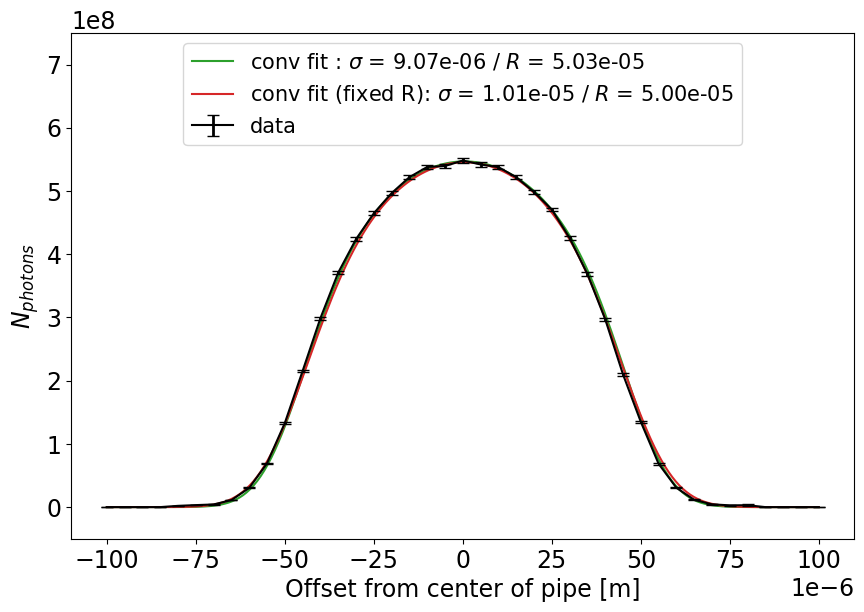

In [26]:
beamWire.PlotConvolution(OFFSETS, NPHOTONS, ERRORS, wireRadius=50e-6, sigma=10e-6)
_plt.ylim(-0.5e8, 7.5e8)
_plt.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
_plt.savefig("{}_photon_beam_scan_and_convolution_fit".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

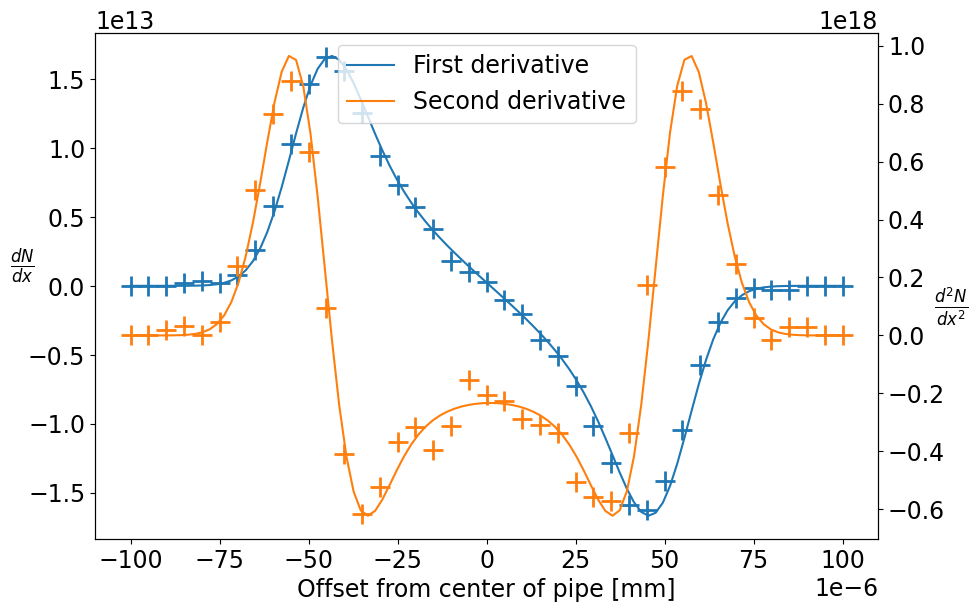

In [27]:
_plt.rcParams['font.size'] = 17
fig, ax = _plt.subplots(1,1,figsize=(9,6))
fig.tight_layout()

ax1 = _plt.gca()
ax2 = ax1.twinx()

X = _np.linspace(-100e-6, 100e-6, 100)
popt, pcov = curve_fit(beamWire.func_conv, OFFSETS, NPHOTONS, p0=[3e9, 10e-6, 0, 50e-6])
grad_func = _np.gradient(beamWire.func_conv(X, A=popt[0], sigma=popt[1], mu=popt[2], R=popt[3]), X)
grad_func_2 = _np.gradient(grad_func, X)

ax1.plot(OFFSETS, _np.gradient(NPHOTONS, OFFSETS), ls='', marker='+', markersize=15, markeredgewidth=2, color='C0')
ax1.plot(X, grad_func, color='C0', label='First derivative')
ax1.set_ylabel(r"$\frac{dN}{dx}$", rotation='horizontal')

ax2.plot(OFFSETS, _np.gradient(_np.gradient(NPHOTONS, OFFSETS), OFFSETS), ls='', marker='+', markersize=15, markeredgewidth=2, color='C1')
ax2.plot(X, grad_func_2, color='C1', label='Second derivative')
ax2.set_ylabel(r"$\frac{d^2N}{dx^2}$", rotation='horizontal')

ax1.set_xlabel('Offset from center of pipe [mm]')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
_plt.legend(h1 + h2, l1 + l2)
_plt.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))

_plt.savefig("{}_derivatives_of_photon_beam_profile".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

REBDSIMCOMBINE analysis file - using RebdsimFile


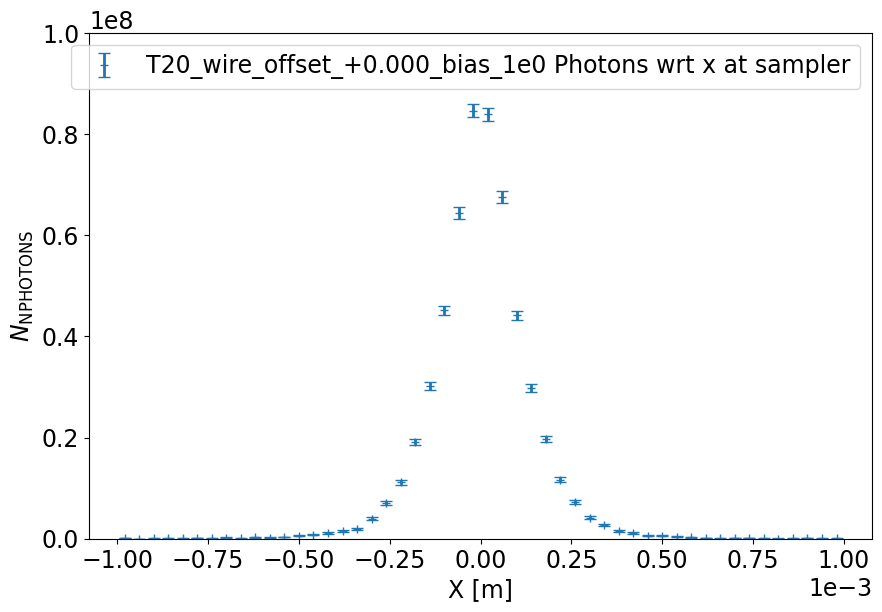

In [29]:
beamWire.plot_hist("../06_analysis/T20_wire_offset_+0.000_bias_1e0_merged_hist.root", "PHOTONS_X", steps=False, errorbars=True)
_plt.ticklabel_format(axis='both', style='sci', scilimits=(1,6))
_plt.ylim(0, 1e8)
_plt.ylabel("$N_{\\rm NPHOTONS}$")
_plt.xlabel("X [m]")
_plt.savefig("{}_photon_beam_X_profile".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

REBDSIMCOMBINE analysis file - using RebdsimFile


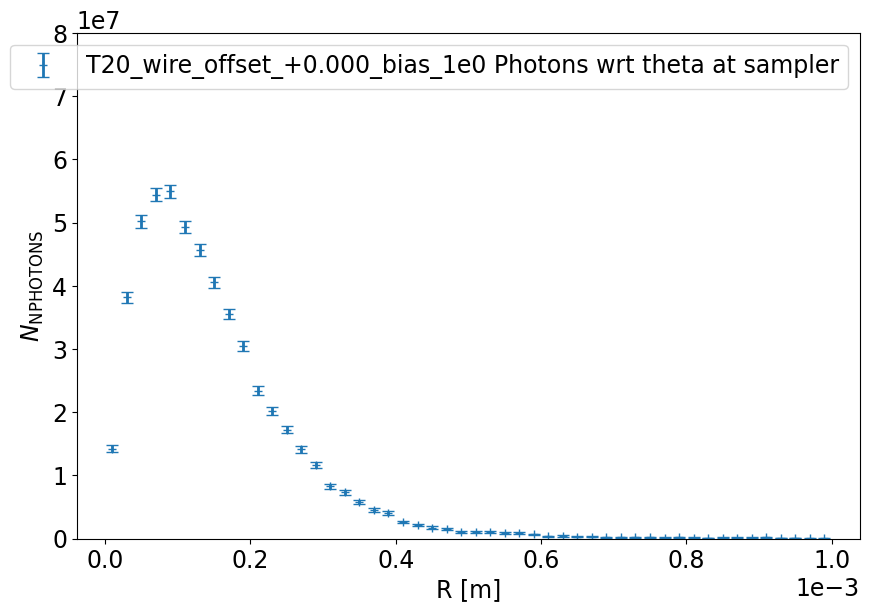

In [31]:
beamWire.plot_hist("../06_analysis/T20_wire_offset_+0.000_bias_1e0_merged_hist.root", "PHOTONS_Theta", steps=False, errorbars=True)
_plt.ticklabel_format(axis='both', style='sci', scilimits=(1,6))
_plt.ylim(0, 8e7)
_plt.ylabel("$N_{\\rm NPHOTONS}$")
_plt.xlabel("R [m]")
_plt.savefig("{}_photon_beam_R_profile".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile


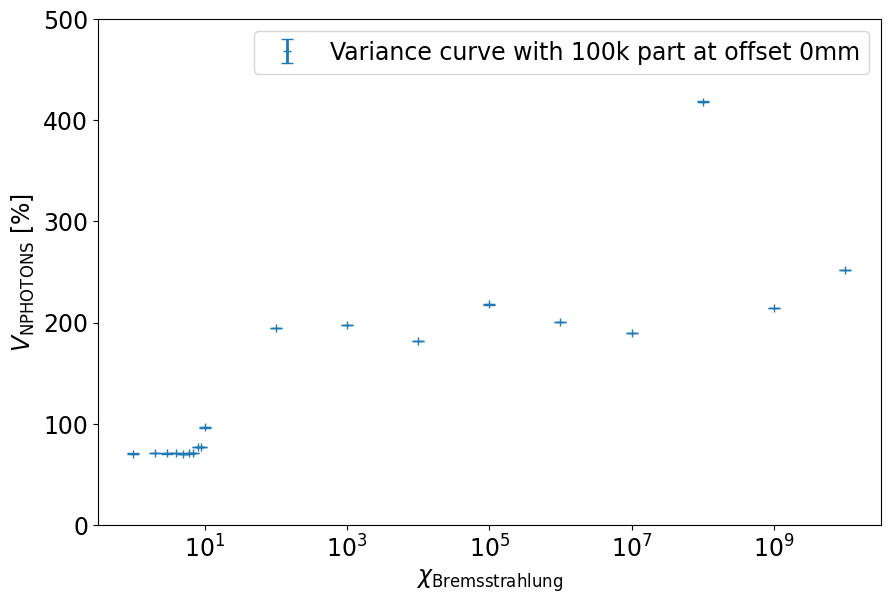

In [14]:
beamWire.plot_var("*T20_for_wire_with_offset_+0.00_bias_*e*_merged_hist.root","PHOTONS_R", errorbars=True, steps=False, xLogScale=True)
_plt.ylabel("$V_{\\rm NPHOTONS}$ [%]")
_plt.xlabel("$\chi_{\\rm Bremsstrahlung}$")
#_plt.xlim(1e0, 1e2)
_plt.ylim(0,500)
_plt.legend(['Variance curve with 100k part at offset 0mm'])
_plt.savefig("{}_Variance_plot_for_wire".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

REBDSIMCOMBINE analysis file - using RebdsimFile


Warning in <TClass::Init>: no dictionary for class BDSOutputROOTEventHeader is available


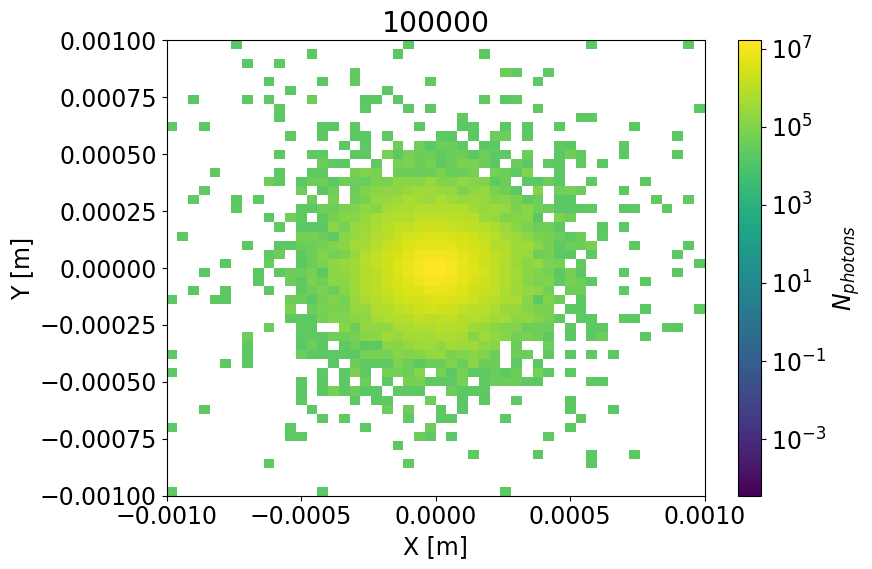

In [17]:
beamWire.plot_hist_2d("../06_analysis/T20_wire_offset_+0.000_bias_1e0_merged_hist.root", "PHOTONS_X_Y",
                      xLogScale=False, yLogScale=False, zLogScale=True,
                      xlabel="X [m]", ylabel="Y [m]", zlabel=r"$N_{photons}$")

_plt.savefig("{}_XY_profile".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

REBDSIMCOMBINE analysis file - using RebdsimFile
REBDSIMCOMBINE analysis file - using RebdsimFile


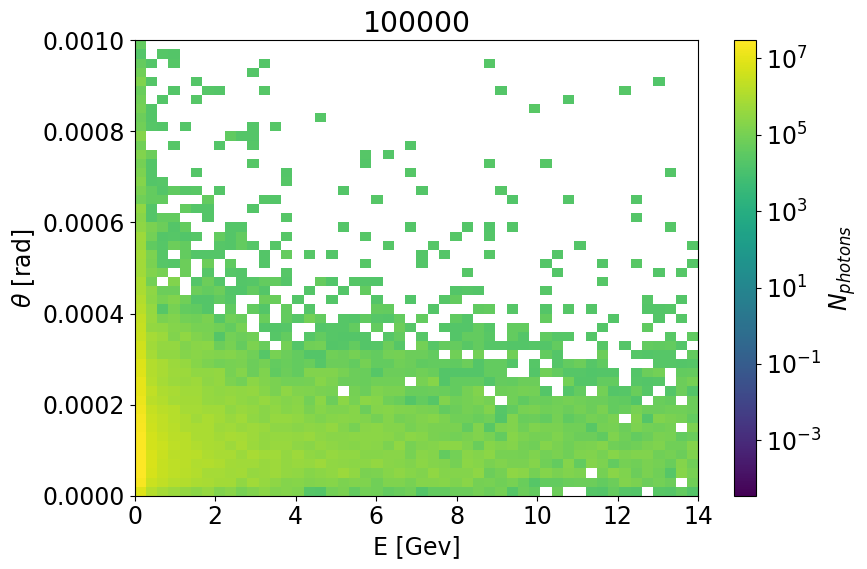

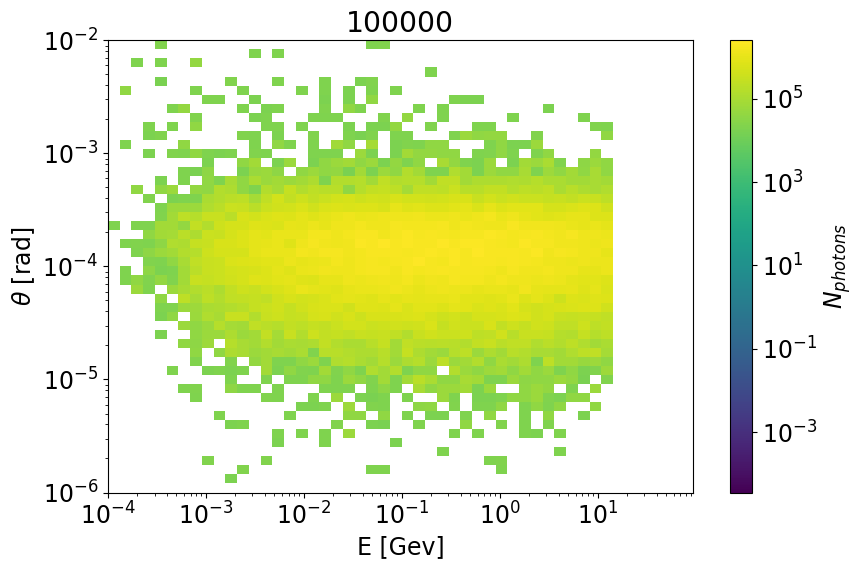

In [19]:
beamWire.plot_hist_2d("../06_analysis/T20_wire_offset_+0.000_bias_1e0_merged_hist.root", "PHOTONS_E_Theta",
                      xLogScale=False, yLogScale=False, zLogScale=True,
                      xlabel="E [Gev]", ylabel=r"$\theta$ [rad]", zlabel=r"$N_{photons}$")

beamWire.plot_hist_2d("../06_analysis/T20_wire_offset_+0.000_bias_1e0_merged_hist.root", "PHOTONS_E_Theta_log",
                      xLogScale=True, yLogScale=True, zLogScale=True,
                      xlabel="E [Gev]", ylabel=r"$\theta$ [rad]", zlabel=r"$N_{photons}$")

_plt.savefig("{}_energy_angle_correlation".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

REBDSIMCOMBINE analysis file - using RebdsimFile


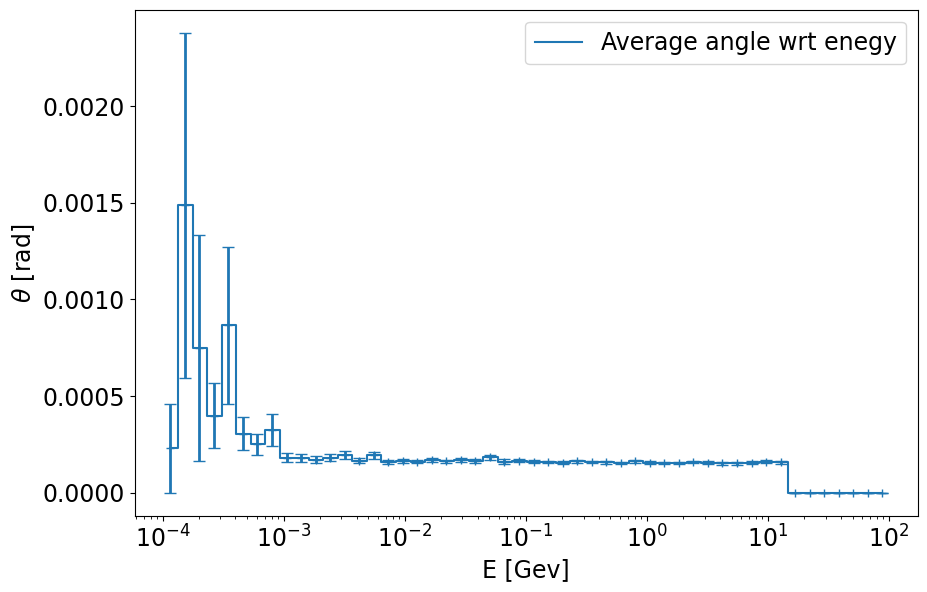

In [33]:
beamWire.plot_Theta_E("../06_analysis/T20_wire_offset_+0.000_bias_1e0_merged_hist.root", "PHOTONS_E_Theta_log", xLogScale=True, yLogScale=False)
_plt.xlabel("E [Gev]")
_plt.ylabel(r"$\theta$ [rad]")
_plt.legend(["Average angle wrt enegy"])

_plt.savefig("{}_average_angle_wrt_energy".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

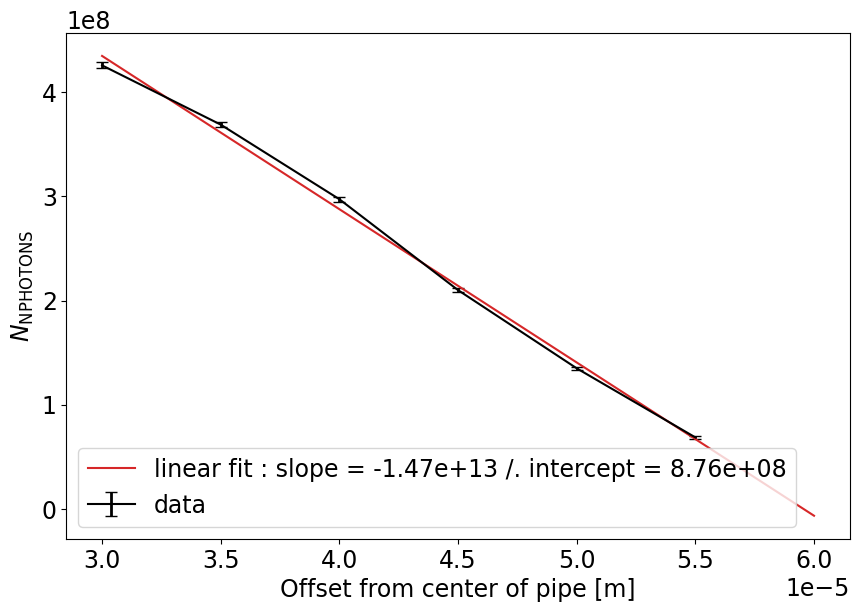

In [34]:
OFF, NPH, ERR = beamWire.countPhotonsInHistAllFiles('../06_analysis/T20_wire_offset_+0.0[3-5][0-9]_bias_1e0_merged_hist.root', 'PHOTONS_R')

def linear(x, a, b):
    return a*x +b

_plt.rcParams['font.size'] = 17
fig, ax = _plt.subplots(1,1,figsize=(9,6))
fig.tight_layout()
_plt.errorbar(OFF, NPH, yerr=ERR, fmt="k", elinewidth=2, capsize=4, label='data')

X = _np.linspace(30e-6, 60e-6, 50)
popt, pcov = curve_fit(linear, OFF, NPH, p0=[3e9, -1e13])
_plt.plot(X, linear(X, a=popt[0], b=popt[1]), '-', color="C3", label='linear fit : slope = {:1.2e} /. intercept = {:1.2e}'.format(popt[0], popt[1]))
_plt.ylabel("$N_{\\rm NPHOTONS}$")
_plt.xlabel('Offset from center of pipe [m]')

_plt.legend()

_plt.savefig("{}_TEST_photon_beam_scan_and_linear_fit".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

In [13]:
#_gl.glob('../04_dataLocal/20000_part_T20_needle_*_Y_+0.00e-3.root')

In [14]:
#beamWire.GenerateLinearListValuesStr(minValue=-1.5, maxValue=0, nbpts=31, nbDecimals=2, exponant=-3)